# Support Vector Machine(SVM)
@Yuwei Hsu

Set up environment

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [ ]:
# Set up style and size for visualization
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 20,"figure.figsize":(18,8)})

In [ ]:
# Acquire dataset
df = pd.read_csv('heart.csv')
print('Shape of dataset',df.shape)

Shape of dataset (1025, 14)


EDA

This dataset consists of four databases, Cleveland, Hungary, Switzerland, and Long Beach V with 14 attributs. The discription of dataset are retrieved from https://archive.ics.uci.edu/ml/datasets/Heart+Disease. We would like to use these descriptions for interpretation purpose.

Data Description:

- age: Age in years
- sex: Sex (1 = male; 0 = female)
- cp: Chest pain type (0 = typical angina; 1 = atypical angina; 2  non-anginal pain; 3 = asymptomatic)
- trestbps: Resting blood pressure in mm Hg on admission to the hospital
- chol: Serum cholestoral in mg/dl
- fbs: Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
- restecg: Resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality; 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
- thalach: Maximum heart rate achieved
- exang: Exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: The slope of the peak exercise ST segment (0 = upsloping; 1 = flat; 2: = downsloping)
- ca: Number of major vessels (0-3) colored by flourosopy
- thal: 1 = normal; 2 = fixed defect; 3 = reversable defect
- target: Diagnosis of heart disease (0 = no disease, 1 = disease)


In [ ]:
df.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0


In [ ]:
df.tail(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1
1024,54,1,0,120,188,0,1,113,0,1.4,1,1,3,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [ ]:
# Check unique value in each feature
for col in df.columns:
  print('{}: {}'.format(col,df[col].unique()))

age: [52 53 70 61 62 58 55 46 54 71 43 34 51 50 60 67 45 63 42 44 56 57 59 64
 65 41 66 38 49 48 29 37 47 68 76 40 39 77 69 35 74]
sex: [1 0]
cp: [0 1 2 3]
trestbps: [125 140 145 148 138 100 114 160 120 122 112 132 118 128 124 106 104 135
 130 136 180 129 150 178 146 117 152 154 170 134 174 144 108 123 110 142
 126 192 115  94 200 165 102 105 155 172 164 156 101]
chol: [212 203 174 294 248 318 289 249 286 149 341 210 298 204 308 266 244 211
 185 223 208 252 209 307 233 319 256 327 169 131 269 196 231 213 271 263
 229 360 258 330 342 226 228 278 230 283 241 175 188 217 193 245 232 299
 288 197 315 215 164 326 207 177 257 255 187 201 220 268 267 236 303 282
 126 309 186 275 281 206 335 218 254 295 417 260 240 302 192 225 325 235
 274 234 182 167 172 321 300 199 564 157 304 222 184 354 160 247 239 246
 409 293 180 250 221 200 227 243 311 261 242 205 306 219 353 198 394 183
 237 224 265 313 340 259 270 216 264 276 322 214 273 253 176 284 305 168
 407 290 277 262 195 166 178 141]
fbs: [0 1]

In [ ]:
# Check missing value
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:
# Check if there exists outliers
outliers = df[~(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print('Number of outlier: ',len(outliers))

Number of outlier:  56


- There are 56 outliers in this dataset, we would drop them before appling model.

In [ ]:
# Remove outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
print('After dropping the outliers, the shape of the data:',df.shape)

After dropping the outliers, the shape of the data: (969, 14)


Visualization

In [ ]:
# Slice column for numerical and categorical features
num_col = ['age','trestbps','chol','thalach','oldpeak']
cat_col = [c for c in df.columns if c not in num_col]
cat_col.remove('target')

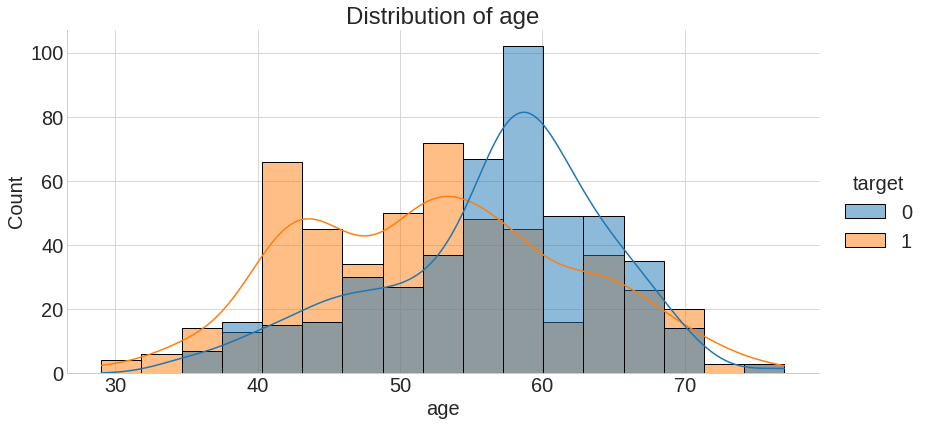

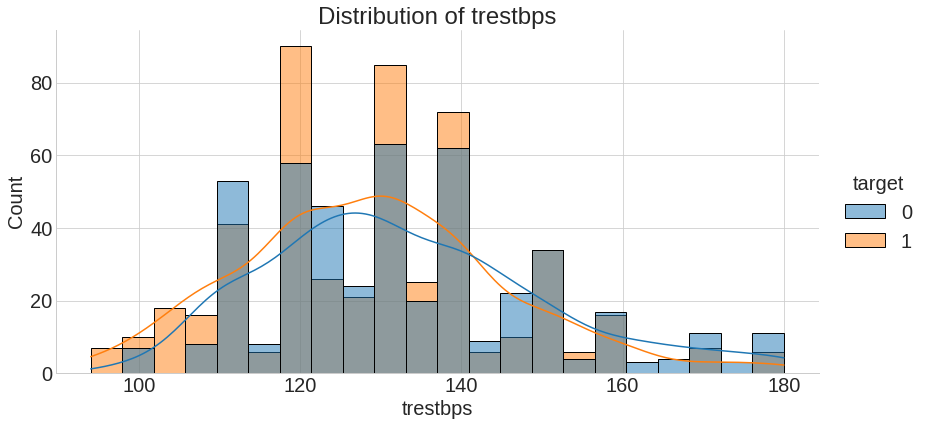

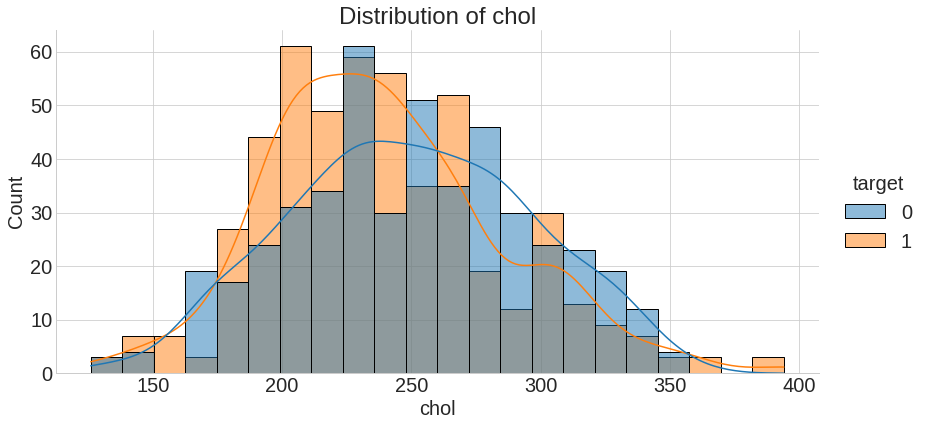

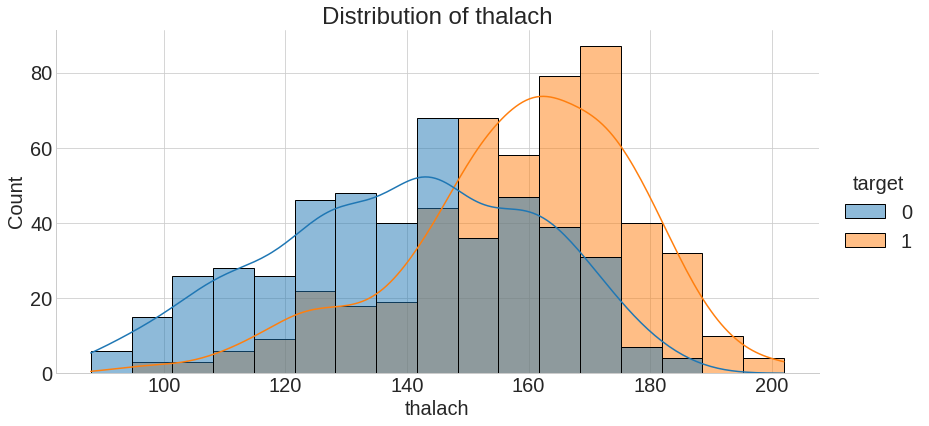

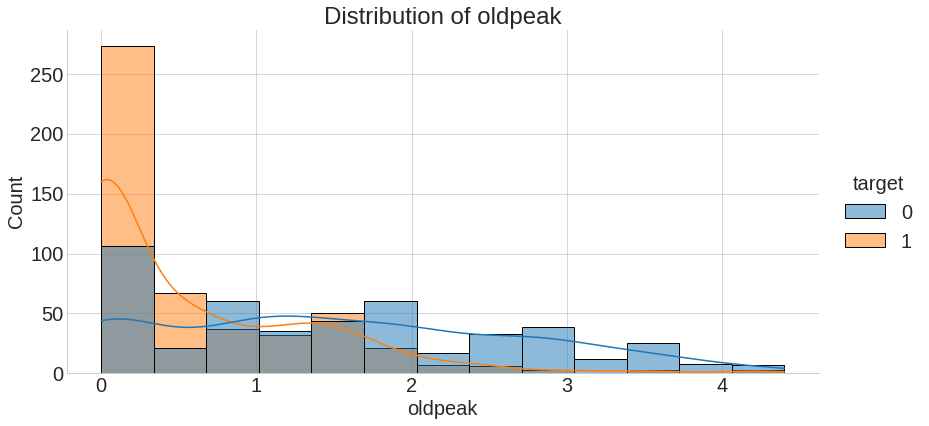

In [ ]:
# Plot the density plot and histogram for numerical features
for col in num_col:
  sns.displot(data= df, x = col, hue = 'target',kde=True,height=6,aspect=2)
  title = 'Distribution of '+ str(col)
  plt.title(title)
  plt.show()

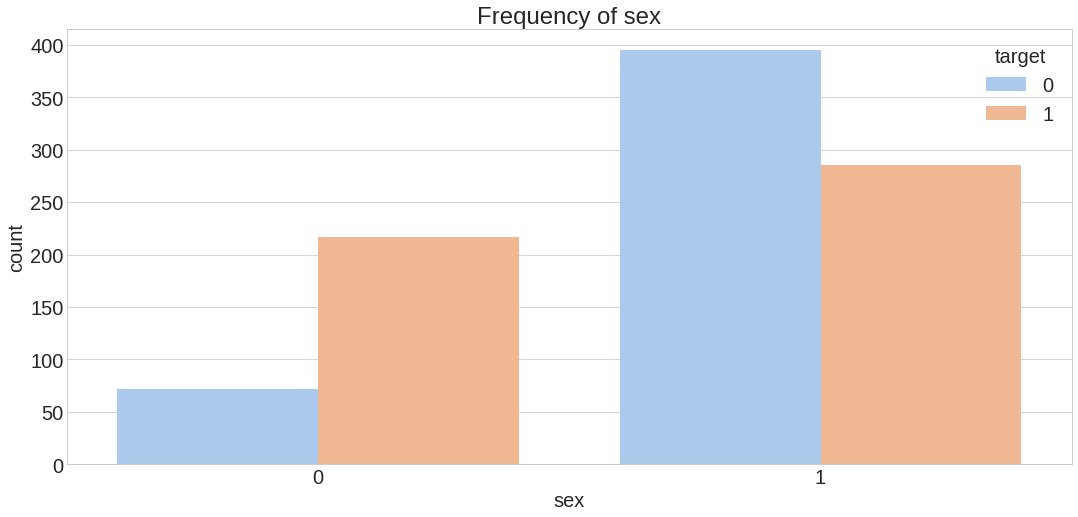

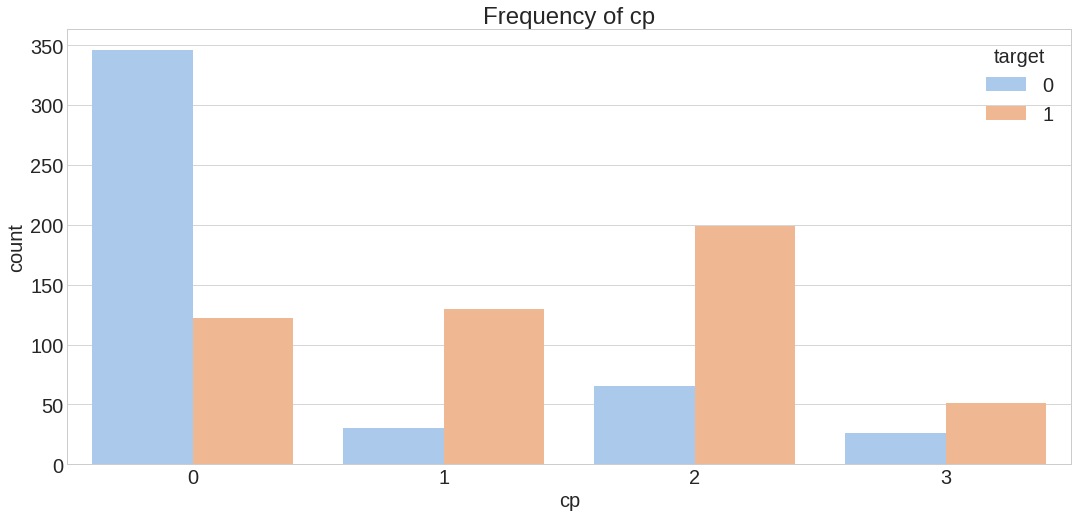

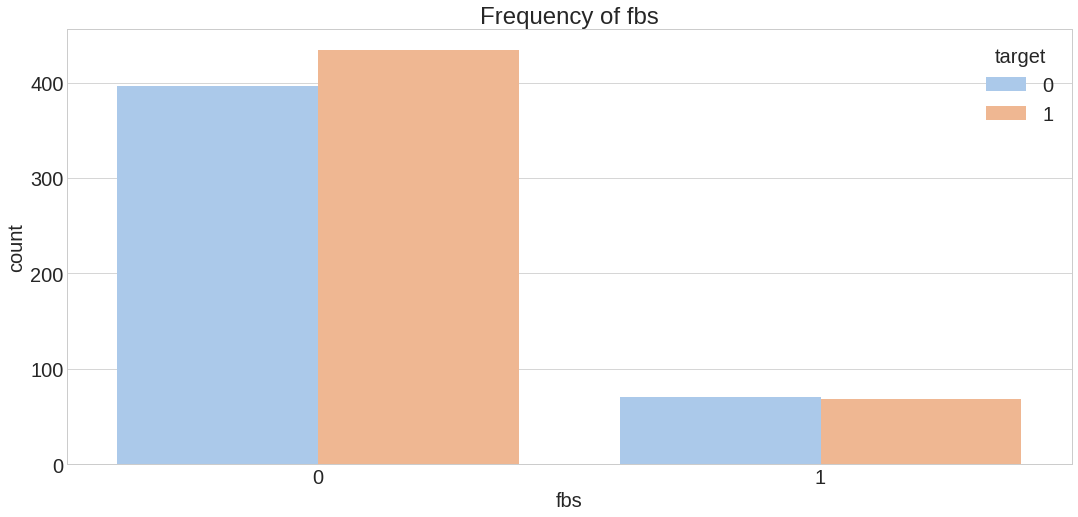

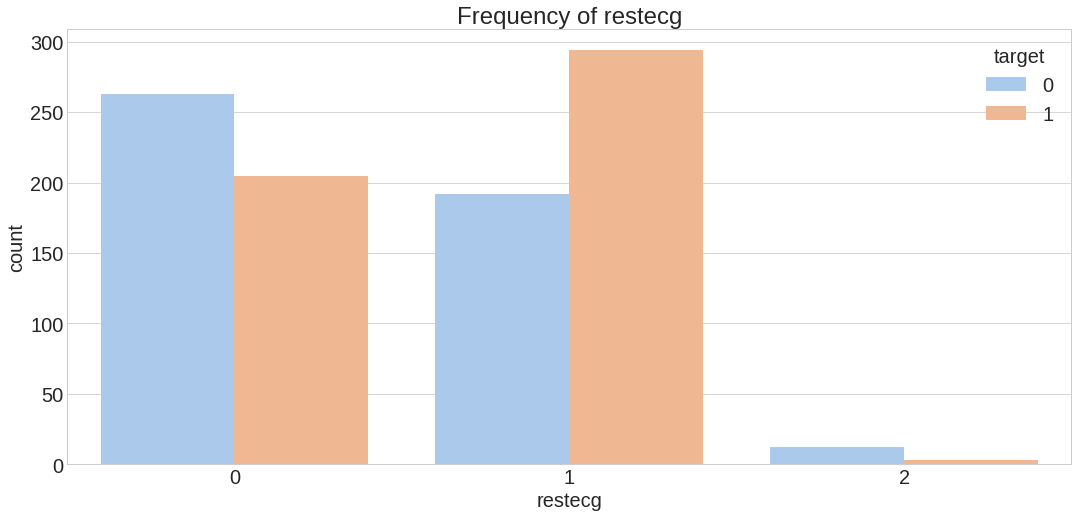

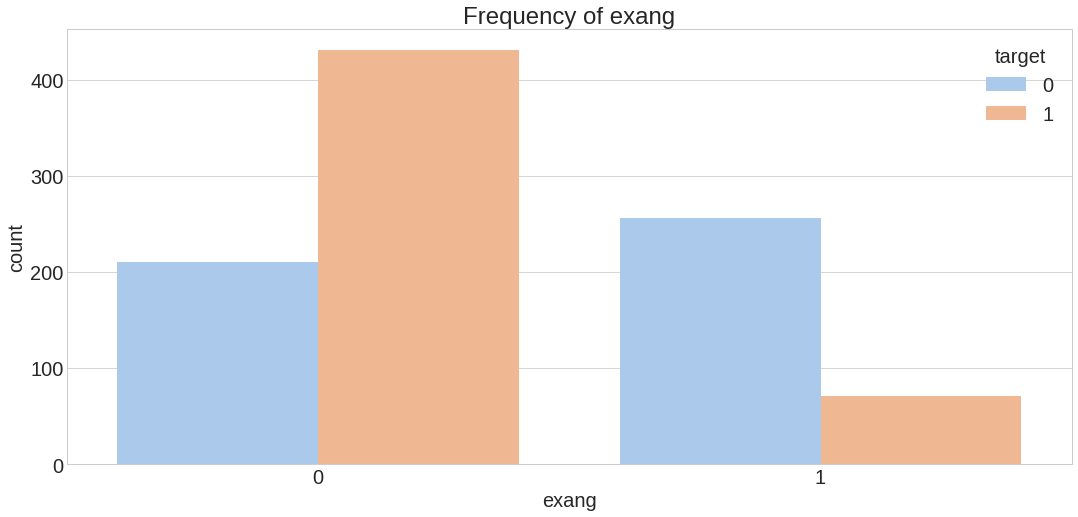

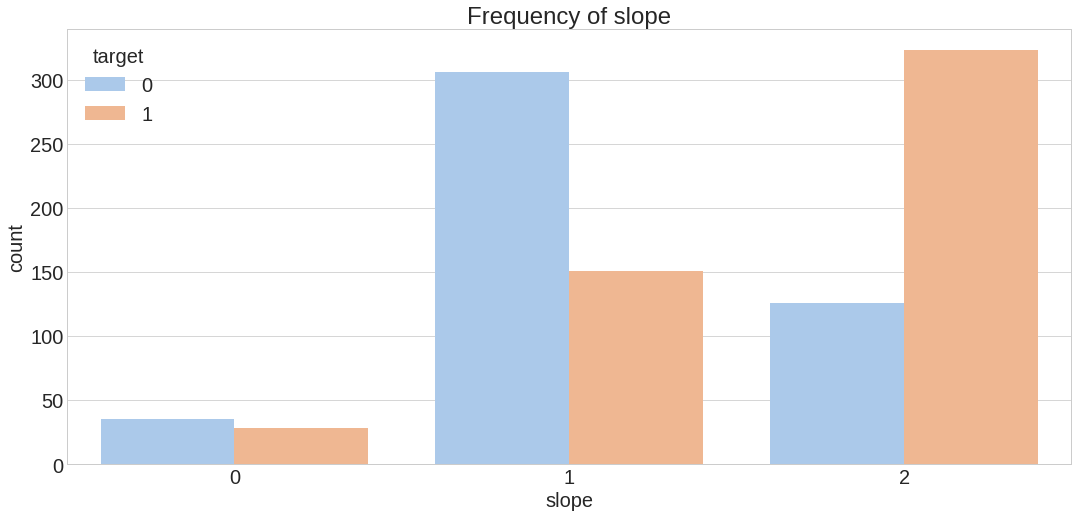

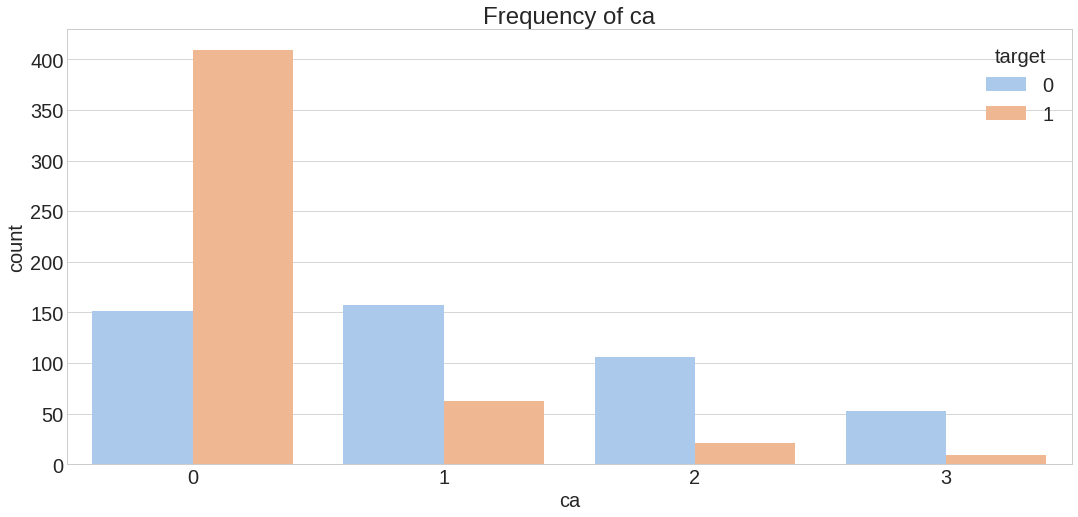

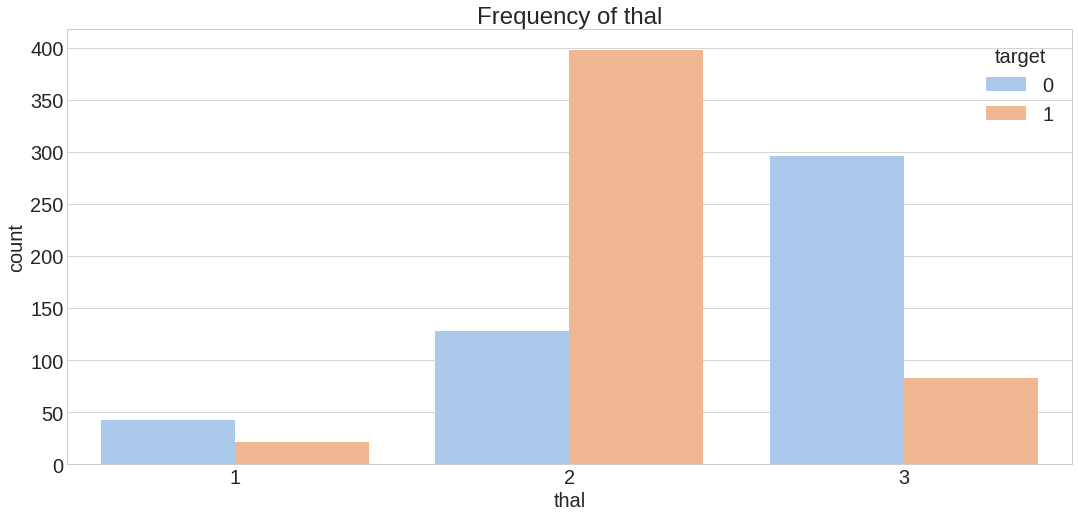

In [ ]:
# Histogram for categorical feature
for col in cat_col:
  ax = sns.countplot(x=col, hue='target', palette='pastel',data=df)
  title = 'Frequency of '+str(col)
  plt.title(title)
  plt.show()

In [ ]:
# Count the percentage of target
df['target'].value_counts(normalize = True)

1    0.51806
0    0.48194
Name: target, dtype: float64

Preprocessing data

In [ ]:
# Normalized numerical data
scaler  = MinMaxScaler()
df[num_col] = scaler.fit_transform(df[num_col])

# Assign X and y for predictor and output
X = df.iloc[:,0:-1]
y = df.iloc[:, -1]

# Split train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Apply Model

In [ ]:
# Fit in model
model = svm.SVC()
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

# Accuracy score and classifiaction report
accuracy =  accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

# Performace
print('\nOverall accuracy:',accuracy)
print('\nClassification Report:')
print(cr)


Overall accuracy: 0.8487972508591065

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       135
           1       0.85      0.88      0.86       156

    accuracy                           0.85       291
   macro avg       0.85      0.85      0.85       291
weighted avg       0.85      0.85      0.85       291



In [ ]:
# Apply GridSearchCV for tuning hyperparameters
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    9.1s finished


- The best hyperparameters of SVC model are C = 1, gamma = 1, degree = 3, and kernel = 'poly'.

In [ ]:
# Fit the best estimator in model
model = grid.best_estimator_
model.fit(X_train, y_train.values)

y_pred = model.predict(X_test)

# Accuracy score and classifiaction report
accuracy =  accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

# Performace
print('\nOverall accuracy:',accuracy)
print('\nClassification Report:')
print(cr)


Overall accuracy: 0.9862542955326461

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       135
           1       0.97      1.00      0.99       156

    accuracy                           0.99       291
   macro avg       0.99      0.99      0.99       291
weighted avg       0.99      0.99      0.99       291



Takeaway:

- By default, the kernel is 'rbk' for the Support Vector Classification model, the overall accuracy is 0.849.
> Precision for both groups is 0.85.

- After tuning the hyperparameters of C(regularization), gamma(kernel coefficient) and kernels by GridSearch cross validation to find the best estimator, the overall accuracy increases to 0.986.
> Precisions for both groups also increase, diagnosed non heart disease(0) is 1 and heart disease(1) is 0.97.
